<a href="https://colab.research.google.com/github/swishswish123/endosim_demo/blob/main/vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/swishswish123/endosim_demo.git

Cloning into 'endosim_demo'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 4), reused 26 (delta 1), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [2]:
!pip install scikit-surgeryvtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 44 kB 2.6 MB/s 
     |████████████████████████████████| 166.0 MB 25 kB/s 
     |████████████████████████████████| 88.3 MB 117 kB/s 
     |████████████████████████████████| 54.5 MB 21 kB/s 
     |████████████████████████████████| 856 kB 68.6 MB/s 
  Created wheel for scikit-surgerycore: filename=scikit_surgerycore-0.6.10-py2.py3-none-any.whl size=23593 sha256=c87fc0609c1a4ffc37417467afb8703ca7ec4e7fa6ef918f6003b23e65cb7c96
  Stored in directory: /root/.cache/pip/wheels/86/96/6c/0127158f4d2a387d5a9d0351acca418cb27c68703a8f88c0b4
  Created wheel for scikit-surgeryimage: filename=scikit_surgeryimage-0.10.1-py2.py3-none-any.whl size=34679 sha256=2a3ae4f4bff30d312d445bfd54151a813cace2d6e159bd5e77357e2f773eba66
  Stored in directory: /root/.cache/pip/wheels/6e/36/0d/50ae6ffaf523db634c2ffc23bf975b95b02

# Vision-based simulation

In this simulation we explore the errors associated with the approach to go directly from the patient coordinates to the MRI coordinates

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image


## Utility functions and imports

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

added / to sys


In [5]:
from endosim_demo.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3


## System layout

The following diagram shows the layout of the navigation system.

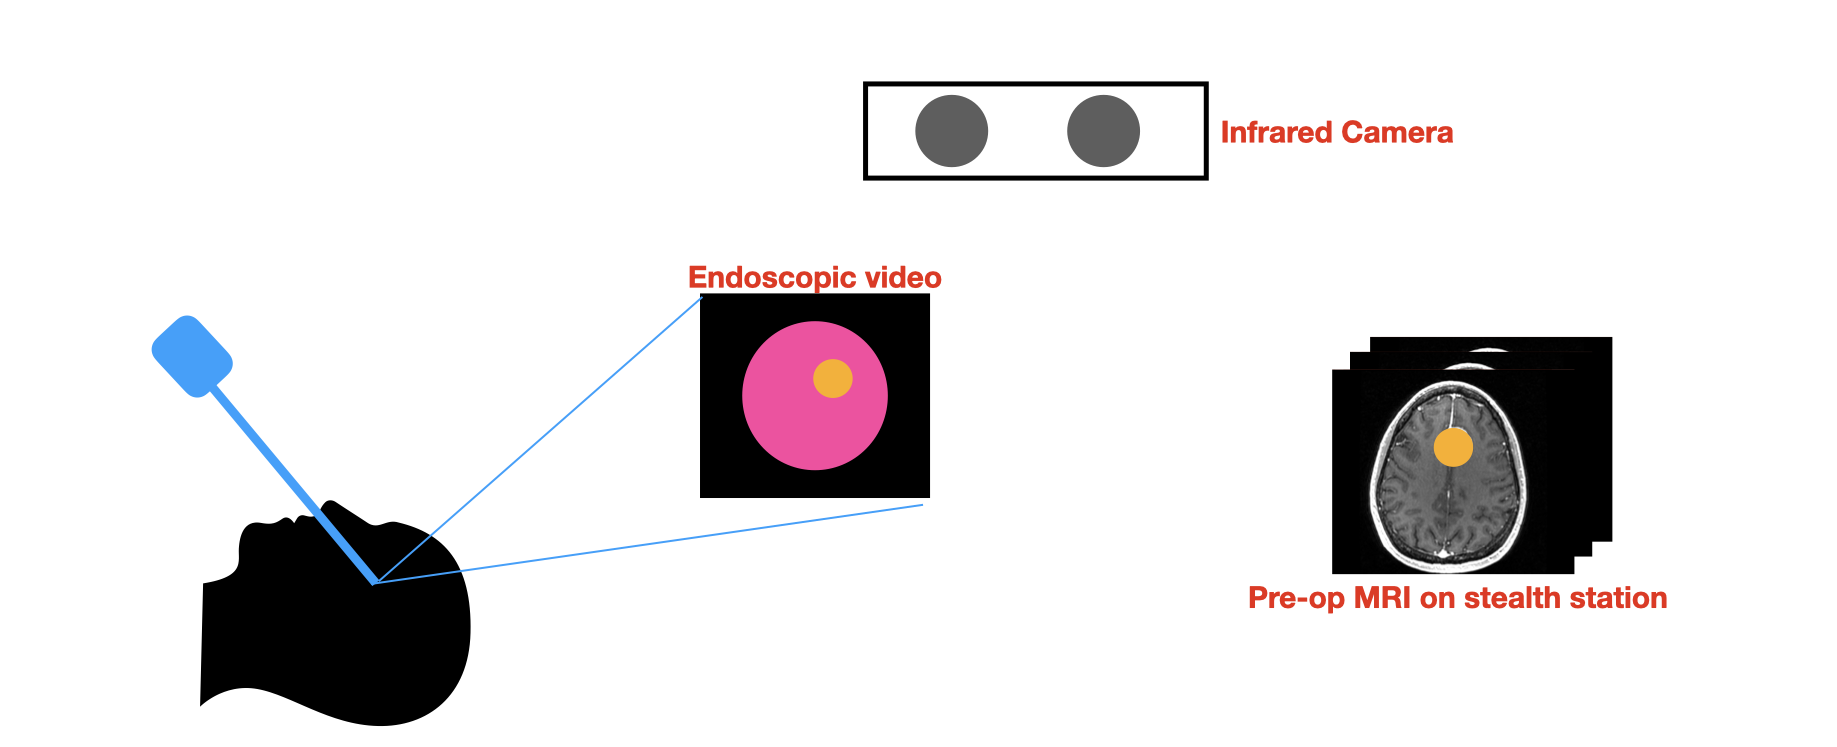

In [6]:
Image(filename="endosim_demo/images/automatic_setup.png")

In the above image, we can see the general setup involved in the surgery when using no tracking and only a vision-based approach. 

The goal, similarly to the endoscope simulation, is to be able to display some segmented piece of information from the pre-operative MRI in MRI coordinates onto the endoscopic video:

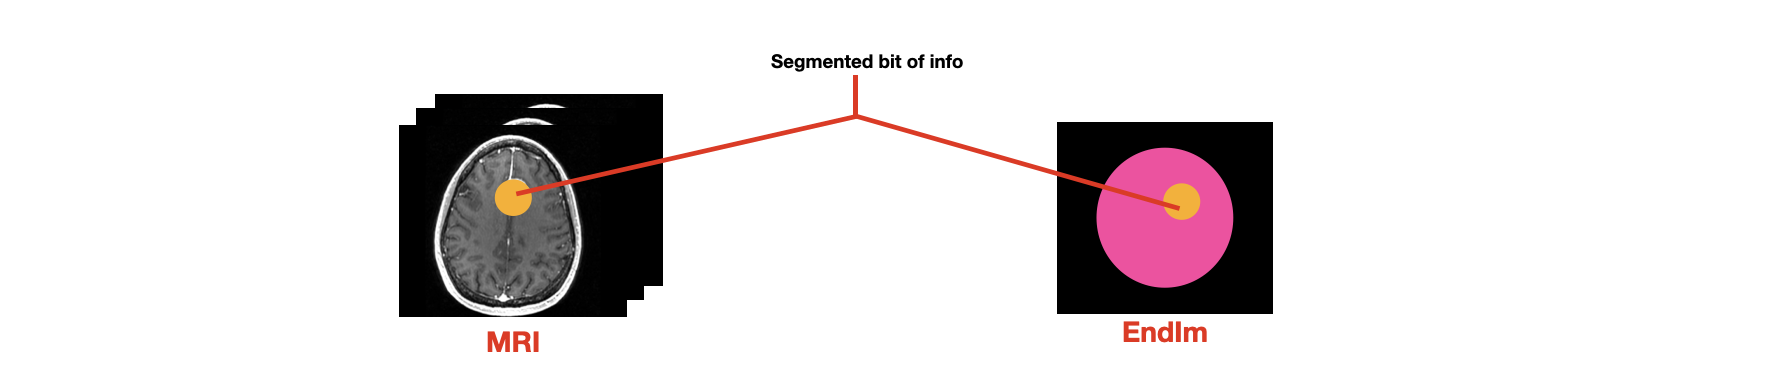

In [7]:
Image(filename="endosim_demo/images/automatic_goal.png")

The goal is therefore turning some segmented MRI coordinates to Endoscopic Image (EndIm) coordinates.

X<sub>EndIm</sub> = <sup>EndIm</sup>T<sub>MRI</sub>  X<sub>MRI</sub>

Below is an visual representation of the vision-based setup with all the transforms:

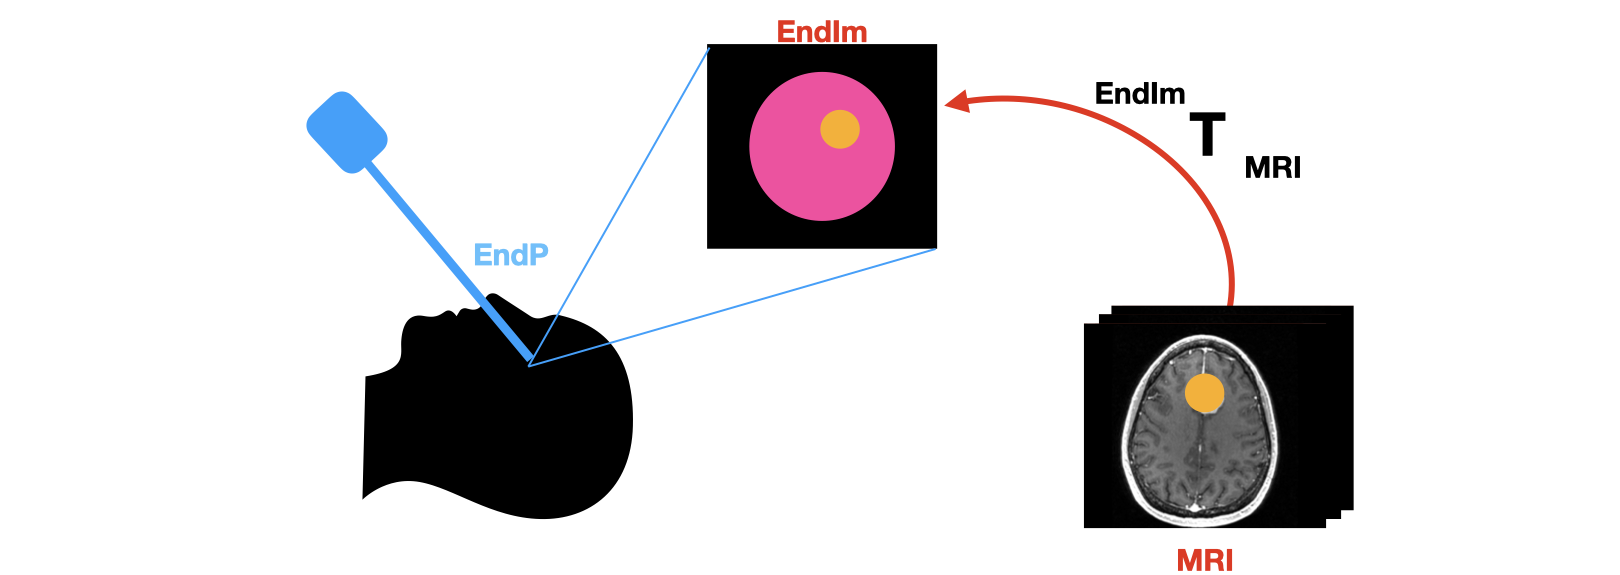

In [8]:
Image(filename="endosim_demo/images/automatic_setup_transforms.png")

# Configurable parameters

If you would like the simulations to go quicker, you can reduce this number but bear in mind the results might be more noisy.

In [9]:
number_samples = 10

# Generating points for registration

We first create a set of 4 points to represent 4 points of the patient's head.

In [10]:
# creating 4 points in patient coordinates

z = 200 # head length (about 20cm)
x = 250 # menton to top of head (about 25cm)
y = 150 # head bredth (about 15cm)

points = np.array(
[
    [-x,-y,z],
    [-x,y,z],
    [x,y,z],
    [x,-y,z],
])


tumour_point = convert_points_nx3_to_1xnx3(np.array([[0,0,0]]))

#points_converted = convert_points_nx3_to_1xnx3(points)


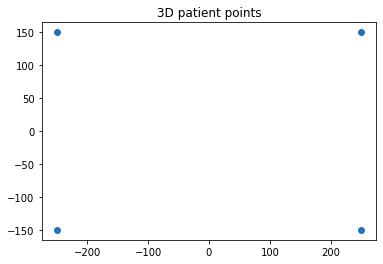

In [11]:
plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.title('3D patient points')
plt.show()

## projecting points from 3D to 2D

We create now the image version of these 3D points by projecting them to 2D.

We use the intrinsics and distortion matrices we got when calibrating the endoscope.

In [12]:
intrinsics = np.loadtxt('endosim_demo/calibration/intrinsics.txt')
distortion = np.loadtxt('endosim_demo/calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))


Intrinsics are:[[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
Distortion coefficients are:[-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]


In [13]:
# converting to format accepted by projectPoints function
points_converted = convert_points_nx3_to_1xnx3(points)
# projecting the 3D points to 2D.
rvec = np.zeros((1,3))
tvec = np.zeros((1,3))
image_points, jacobian = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
# removing extra empty dimension
image_points = image_points.squeeze()
print(image_points)

[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


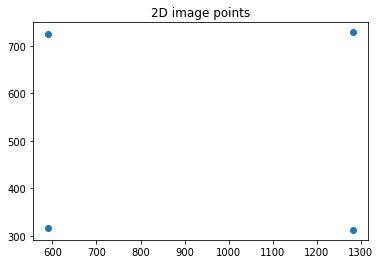

In [14]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.title('2D image points')
plt.show()

# Simulation 1: adding noise to image points (2D)

In this simulation we test the outcome of adding noise to the 2D image points for different values of sigma.

In [15]:
# points-3D
# image_points-2D
# image_points_noisy-2D noisy

First we add noise to the image points (that is- add noise in 2D)

In [16]:
sigma=0.25
image_points_noisy = add_noise_to_points(image_points,sigma)

We then find the corresponding transformation to match the 2D image points to the corresponding 3D locations

In [17]:
# finding transform to get us from 2D image points to 3D object
success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )
# finding transform to get us from NOISY 2D image points to 3D object
success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )

if success_true:
    print(f'rotation true:, {rotation_vector_true}')
    print(f'translation true:, {translation_vector_true}')
else:
    print('solution not found')

if success:
    print(f'rotation noisy:, {rotation_vector}')
    print(f'translation noisy:, {translation_vector}')
else:
    print('solution not found')
    

        

rotation true:, [[-1.33849327e-04]
 [ 1.53026096e-02]
 [ 2.27516157e-07]]
translation true:, [[-2.08313803e+00]
 [-1.82287484e-02]
 [ 2.01168074e+02]]
rotation noisy:, [[-0.00064583]
 [ 0.01548181]
 [ 0.00030233]]
translation noisy:, [[-2.10482812e+00]
 [-1.62379812e-01]
 [ 2.01117842e+02]]


Finally we project the 3D points to 2D with the true and noisy rotation and translation

In [18]:
point_projected2D_true, jacobian = cv2.projectPoints(points_converted, rotation_vector_true, translation_vector_true, intrinsics, distortion)
point_projected2D_true = point_projected2D_true.squeeze()
print(f'true projected points: {point_projected2D_true}')

point_projected2D, jacobian = cv2.projectPoints(points_converted, rotation_vector, translation_vector, intrinsics, distortion)
point_projected2D = point_projected2D.squeeze()
print(f'noisy projected points: {point_projected2D}')

true projected points: [[ 590.71083943  315.32212628]
 [ 590.68341083  726.00576517]
 [1281.25122558  729.16991962]
 [1281.22322562  312.15831522]]
noisy projected points: [[ 590.83790954  315.19010419]
 [ 590.58079336  725.88328552]
 [1281.3149482   729.28091634]
 [1281.30522683  312.20499569]]


We can also use this rotation and translation to transform any other point in this coordinate system- eg. a point where the caner is locaed


In [19]:
tumour_projected2D_true, jacobian = cv2.projectPoints(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
tumour_projected2D_true = tumour_projected2D_true.squeeze()
print(f'true projected tumour location{tumour_projected2D_true}')

tumour_projected2D, jacobian = cv2.projectPoints(tumour_point, rotation_vector, translation_vector, intrinsics, distortion)
tumour_projected2D = tumour_projected2D.squeeze()
print(f'noisy projected tumour location: {tumour_projected2D}')


true projected tumour location[924.64967063 520.57989916]
noisy projected tumour location: [924.57629059 520.10411719]


We can visualise what this 2D error looks like by plotting the noisy and regular points:

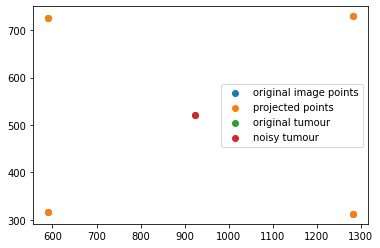

In [20]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(point_projected2D[:,0], point_projected2D[:,1])

plt.scatter(tumour_projected2D[0], tumour_projected2D[1])
plt.scatter(tumour_projected2D_true[0], tumour_projected2D_true[1])

plt.legend(['original image points', 'projected points', 'original tumour', 'noisy tumour'])

plt.show()

# Error in 3D------------ still don't know how to do this

In [21]:
tumour_projected2D

success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )


In [22]:
print(f'tumour 3D true: {tumour_point}')
print(f'tumour 2D true: {tumour_projected2D_true}')
print(f'rotation true:, {rotation_vector_true}')
print(f'translation true:, {translation_vector_true}')

print(f'tumour 2D error: {tumour_projected2D}')
print(f'rotation:, {rotation_vector}')
print(f'translation:, {translation_vector}')


tumour 3D true: [[[0. 0. 0.]]]
tumour 2D true: [924.64967063 520.57989916]
rotation true:, [[-1.33849327e-04]
 [ 1.53026096e-02]
 [ 2.27516157e-07]]
translation true:, [[-2.08313803e+00]
 [-1.82287484e-02]
 [ 2.01168074e+02]]
tumour 2D error: [924.57629059 520.10411719]
rotation:, [[-0.00064583]
 [ 0.01548181]
 [ 0.00030233]]
translation:, [[-2.10482812e+00]
 [-1.62379812e-01]
 [ 2.01117842e+02]]


In [23]:
# tumour_projected2D @ intrinsics.T
# intrinsics.T @ 


In [24]:

'''
original_undistorted = cv2.undistortPoints(tumour_projected2D, intrinsics, distortion)
noisy_undistorted = cv2.undistortPoints(tumour_projected2D_true, intrinsics, distortion)

t = translation_vector_true[:,0]
r = rotation_vector_true[:,0]

params = [t[0], t[1], t[2],r[0], r[1], r[2]]  

Q=rigid_body_parameters_to_matrix(params)

cv2.reprojectImageTo3D(tumour_projected2D, intrinsics)
'''

'\noriginal_undistorted = cv2.undistortPoints(tumour_projected2D, intrinsics, distortion)\nnoisy_undistorted = cv2.undistortPoints(tumour_projected2D_true, intrinsics, distortion)\n\nt = translation_vector_true[:,0]\nr = rotation_vector_true[:,0]\n\nparams = [t[0], t[1], t[2],r[0], r[1], r[2]]  \n\nQ=rigid_body_parameters_to_matrix(params)\n\ncv2.reprojectImageTo3D(tumour_projected2D, intrinsics)\n'

In [25]:
zero_dist = np.zeros((1,len(distortion)))

In [26]:
point_projected2D_no_dist, jacobian = cv2.projectPoints(points_converted, rotation_vector_true, translation_vector_true, intrinsics, zero_dist)
point_projected2D_no_dist

array([[[ 522.90649236,  274.78469917]],

       [[ 522.865359  ,  766.54842593]],

       [[1351.33663388,  771.28335291]],

       [[1351.29483897,  270.04994095]]])

In [27]:
point_projected2D_true, jacobian = cv2.projectPoints(points_converted, rotation_vector_true, translation_vector_true, intrinsics, distortion)
point_projected2D_true

array([[[ 590.71083943,  315.32212628]],

       [[ 590.68341083,  726.00576517]],

       [[1281.25122558,  729.16991962]],

       [[1281.22322562,  312.15831522]]])

In [28]:
for point in points_converted[0,:,:]:
    
    projected_point = intrinsics@point
    print(projected_point[:2]/projected_point[2])

[100.7402913   22.76595842]
[ 100.7402913  1018.51413552]
[1762.3227328  1018.51413552]
[1762.3227328    22.76595842]


In [29]:
distortion

array([-4.0929449e-01,  2.1631278e-01,  1.1120000e-05,  1.2712000e-03,
       -7.2057120e-02])

In [30]:
image_points

array([[ 590.70593181,  315.33086881],
       [ 590.67821662,  725.99720692],
       [1281.2560626 ,  729.16169462],
       [1281.2283474 ,  312.1663811 ]])

In [31]:
points_hom = np.ones((4,4))
points_hom[:3]=points.T

Investigating effects of different sigmas

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each image point
*     match noisy 2D and original 3D points to get transform matrices
*     project original 3D points using this noisy transformation
*     measure Euclidean distance in MRI space between noisy image and normal image 2D points
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

when adding 2D noise, number of pxls off at sigma 0.12 is 0.7203837937925285
when adding 2D noise, number of pxls off at sigma 0.15 is 0.9462039447075117
when adding 2D noise, number of pxls off at sigma 0.25 is 1.6589564616189765


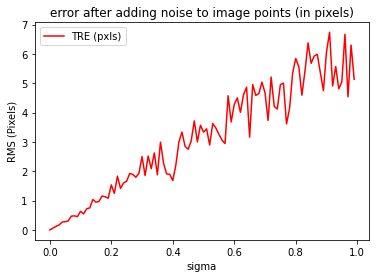

In [32]:

x_values_px_1 = []
y_values_px_1 = []

#x_values_mm = []
#y_values_mm = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # add noise to image points
        image_points_noisy = add_noise_to_points(image_points,sigma)
        
        # try and match noisy 2D to original 3d object points
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics,distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics,distortion, flags=0 )

        # project tumour 3D point using the found rotations and translations
        # true
        point_projected2D_true, _ = cv2.projectPoints(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        point_projected2D_true = point_projected2D_true.squeeze()
        # noisy
        point_projected2D, _ = cv2.projectPoints(tumour_point, rotation_vector, translation_vector, intrinsics, distortion)
        point_projected2D = point_projected2D.squeeze()

        # 3D noise
        
        #original_undistorted = cv2.undistortPoints(point_projected2D, intrinsics, distortion)
        #noisy_undistorted = cv2.undistortPoints(point_projected2D, intrinsics, distortion)

        
        euclid_dist_px =  (point_projected2D_true[0] - point_projected2D[0]) \
                     * (point_projected2D_true[0] - point_projected2D[0]) \
                     + (point_projected2D_true[1] - point_projected2D[1]) \
                     * (point_projected2D_true[1] - point_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        D2_25 = rms
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_25}')
    if sigma == 0.12:
        D2_12 = rms
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_12}')
    if sigma == 0.15:
        D2_15 = rms
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_15}')       
    x_values_px_1.append(sigma)
    y_values_px_1.append(rms)
    
plt.plot(x_values_px_1, y_values_px_1, 'r', label='TRE (pxls)')
plt.title('error after adding noise to image points (in pixels)')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (Pixels)')
plt.show()


## Simulation 2: adding noise to 3D


In this simulation we investigate the effect of adding noise to the 3D points before projecting for different sigma values.

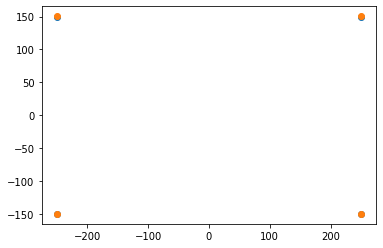

In [33]:
noisy_points = add_noise_to_points(points, 0.5)

plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.scatter(noisy_points[:,0], noisy_points[:,1])
plt.show()


Project both noisy points and real points to 2D

In [34]:
image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
image_points = image_points.squeeze()
image_points_noisy = image_points_noisy.squeeze()

Find transformations to get from 3D to 2D

In [35]:
success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )

success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )


Use these transformations to transform a tumour

In [36]:
tumour_projected2D_true, _ = cv2.projectPoints(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
tumour_projected2D_true = tumour_projected2D_true.squeeze()
print(tumour_projected2D_true)

tumour_projected2D, _ = cv2.projectPoints(tumour_point, rotation_vector, translation_vector, intrinsics, distortion)
tumour_projected2D = tumour_projected2D.squeeze()
print(tumour_projected2D)

[924.64967063 520.57989916]
[937.48515803 538.42429397]


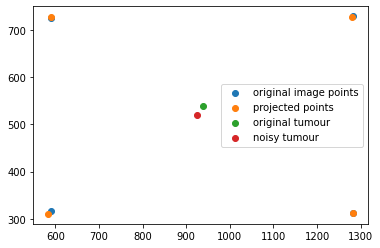

In [37]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])

plt.scatter(tumour_projected2D[0], tumour_projected2D[1])
plt.scatter(tumour_projected2D_true[0], tumour_projected2D_true[1])

plt.legend(['original image points', 'projected points', 'original tumour', 'noisy tumour'])

plt.show()

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each object point (3D)
*     project both noisy and original 3D object points
*     match regular 2D and noisy 3D points to get transform matrices
*     project 3D original tumour location using this noisy transformation
*     measure Euclidean distance in MRI space between projecting the tumour with noisy transform as opposed to non-noisy

*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

when adding 3D noise, number of pxls off at sigma 0.12 is 3.9125086242126588
when adding 3D noise, number of pxls off at sigma 0.15 is 5.6681834702931235
when adding 3D noise, number of pxls off at sigma 0.25 is 10.339703016444954


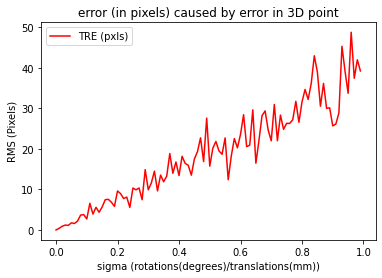

In [38]:

x_values_px_2 = []
y_values_px_2 = []

#x_values_mm = []
#y_values_mm = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
        image_points = image_points.squeeze()
        image_points_noisy = image_points_noisy.squeeze()
    
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )
        
        # project tumour 3D point using the found rotations and translations
        # true
        tumour_projected2D_true, _ = cv2.projectPoints(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        tumour_projected2D_true = tumour_projected2D_true.squeeze()
        # noisy
        tumour_projected2D, _ = cv2.projectPoints(tumour_point, rotation_vector, translation_vector, intrinsics, distortion)
        tumour_projected2D = tumour_projected2D.squeeze()

        
        euclid_dist_px =  (tumour_projected2D_true[0] - tumour_projected2D[0]) \
                     * (tumour_projected2D_true[0] - tumour_projected2D[0]) \
                     + (tumour_projected2D_true[1] - tumour_projected2D[1]) \
                     * (tumour_projected2D_true[1] - tumour_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        D3_25 = rms
        print(f'when adding 3D noise, number of pxls off at sigma {sigma} is {D3_25}')
    if sigma == 0.12:
        D3_12 = rms
        print(f'when adding 3D noise, number of pxls off at sigma {sigma} is {D3_12}')
    if sigma == 0.15:
        D3_15 = rms
        print(f'when adding 3D noise, number of pxls off at sigma {sigma} is {D3_15}')
                    
        
    x_values_px_2.append(sigma)
    y_values_px_2.append(rms)
    
plt.plot(x_values_px_2, y_values_px_2, 'r', label='TRE (pxls)')
plt.title('error (in pixels) caused by error in 3D point')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


## Simulation 3: adding noise to both

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each object point (3D)
*     project both noisy and original 3D object points to 2D
*     add zero mean Gaussian(sigma) noise to each 2D image point of the noisy projected points
*     match noisy 2D with original 3D points to get transform matrices
*     project tumour 3D location using this noisy transformation
*     measure Euclidean distance in MRI space between projecting the tumour with noisy transform as opposed to non-noisy
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

when adding 3D noise and 2D noise, number of pxls off at sigma 0.12 is 3.833796288195604
when adding 3D noise and 2D noise, number of pxls off at sigma 0.15 is 4.944646097547621
when adding 3D noise and 2D noise, number of pxls off at sigma 0.25 is 7.272346017248182


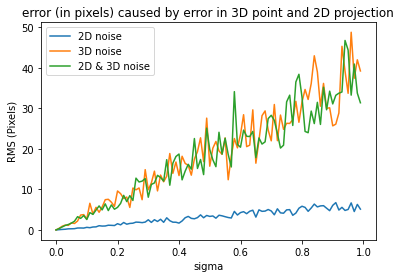

In [39]:

x_values_px_3 = []
y_values_px_3 = []

#x_values_mm = []
#y_values_mm = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
        image_points = image_points.squeeze()
        image_points_noise_3D = image_points_noisy.squeeze()
        #print(image_points_noise_3D)
        # add noise to 2D points
        image_points_noisy = add_noise_to_points(image_points_noise_3D,sigma)
        #print(image_points_noisy)
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )
        
        # project tumour 3D point using the found rotations and translations
        # true
        tumour_projected2D_true, _ = cv2.projectPoints(tumour_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        tumour_projected2D_true = tumour_projected2D_true.squeeze()
        # noisy
        tumour_projected2D, _ = cv2.projectPoints(tumour_point, rotation_vector, translation_vector, intrinsics, distortion)
        tumour_projected2D = tumour_projected2D.squeeze()

        
        euclid_dist_px =  (tumour_projected2D_true[0] - tumour_projected2D[0]) \
                     * (tumour_projected2D_true[0] - tumour_projected2D[0]) \
                     + (tumour_projected2D_true[1] - tumour_projected2D[1]) \
                     * (tumour_projected2D_true[1] - tumour_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        D3D2_25 = rms
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_25}')
    if sigma == 0.12:
        D3D2_12 = rms
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_12}')
    if sigma == 0.15:
        D3D2_15 = rms
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_15}')
            
    x_values_px_3.append(sigma)
    y_values_px_3.append(rms)
    
plt.plot(x_values_px_1, y_values_px_1, label='2D noise')
plt.plot(x_values_px_2, y_values_px_2, label='3D noise')
plt.plot(x_values_px_3, y_values_px_3, label='2D & 3D noise')

plt.title('error (in pixels) caused by error in 3D point and 2D projection')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (Pixels)')
plt.show()
